In [1]:
import numpy as np
from ngsolve import *
from netgen.geom2d import unit_square

from pymor.algorithms.pod import pod
from pymor.vectorarrays.numpy import NumpyVectorSpace
import matplotlib.pyplot as plt

In [2]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
V = H1(mesh, order=3, dirichlet="left|bottom|top")
u, v = V.TnT()

f = LinearForm(V)
f += 32 * (y * (1 - y) + x * (1 - x)) * v * dx
f.Assemble()
f_vec = np.array(f.vec)

g = LinearForm(V)
g += 1 * v * ds("right")
g.Assemble()
g_vec = np.array(g.vec)

# --- Reference bilinear forms for each κ entry ---
a11 = BilinearForm(V, symmetric=True)
a11 += grad(u)[0] * grad(v)[0] * dx
a11.Assemble()

a12 = BilinearForm(V, symmetric=False)
a12 += grad(u)[1] * grad(v)[0] * dx
a12.Assemble()

a22 = BilinearForm(V, symmetric=True)
a22 += grad(u)[1] * grad(v)[1] * dx
a22.Assemble()

# Reference linear form
f_neumann = LinearForm(V)
f_neumann += 1 * v * ds("right")
f_neumann.Assemble()

# Full-order solve for given κ
def solve_full(kappa: np.ndarray, mu_2: float = 2.0) -> np.ndarray:
    """kappa: 2x2 array-like of floats."""
    a_mu = BilinearForm(V, symmetric=True)
    a_mu += kappa[0] * grad(u)[0] * grad(v)[0] * dx
    a_mu += kappa[1] * grad(u)[1] * grad(v)[0] * dx
    a_mu += kappa[1] * grad(u)[0] * grad(v)[1] * dx
    a_mu += kappa[2] * grad(u)[1] * grad(v)[1] * dx
    a_mu.Assemble()
    
    f_mu = LinearForm(V)
    f_mu += mu_2 * v * ds("right")
    f_mu += 32 * (y * (1 - y) + x * (1 - x)) * v * dx
    f_mu.Assemble()
    
    gfu = GridFunction(V)
    gfu.vec.data = a_mu.mat.Inverse(V.FreeDofs()) * f_mu.vec
    return np.array(gfu.vec)  # shape (ndofs,)


In [3]:
kappa_test = np.array([1,-0.5,2])
mu_2_test = 1.0
u_fom = solve_full(kappa_test,mu_2=mu_2_test)

from ngsolve.webgui import Draw
gfu_fom = GridFunction(V); gfu_fom.vec[:] = u_fom
Draw(gfu_fom, mesh, "FOM")

# VTKOutput(ma=mesh, coefs=[gfu_fom], names=["u"], filename="poisson", subdivision=0).Do()

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [4]:
# snapshot generation for multiple κ samples
ntrain = 100

# --- κ sampler: symmetric positive-definite, bounded anisotropy ---
def sample_anisotropic_spd(k_min=0.01, k_max=20, max_anisotropy=20.0):
    lam1 = np.random.uniform(k_min, k_max)
    r = np.random.uniform(1.0, max_anisotropy)
    lam2 = np.clip(lam1 * r if np.random.rand() < 0.5 else lam1 / r, k_min, k_max)
    theta = np.random.uniform(0, 2*np.pi)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    kappa = R @ np.diag([lam1, lam2]) @ R.T
    return np.array([kappa[0,0],kappa[1,0],kappa[1,1]])

kappas = []
snapshots = []

for i in range(ntrain):
    kappa = sample_anisotropic_spd(k_min=0.01, k_max=20.0, max_anisotropy=20.0)
    kappas.append(kappa)
    mu2 = np.random.uniform(-10, 10.0)
    snapshots.append(solve_full(kappa=kappa, mu_2=mu2))

X = np.column_stack(snapshots)           # (ndofs, nsnap)
ndofs, nsnap = X.shape
print(f"ndofs={ndofs}, nsnapshots={nsnap}")


ndofs=1096, nsnapshots=100


In [5]:
# POD basis construction
from pymor.operators.numpy import NumpyMatrixOperator
max_modes = 100

space = NumpyVectorSpace(ndofs)
snapshots_va = space.from_numpy(X.T)     # shape (nsnap, ndofs)

# Mass matrix
m = BilinearForm(V, symmetric=True)
m += u*v*dx
m.Assemble()

# Stiffness matrix
s = BilinearForm(V, symmetric=True)
s += grad(u)*grad(v)*dx
s.Assemble()

# H1 inner product
H1_mat = np.array(s.mat.ToDense()+m.mat.ToDense())
H1_semi_mat = np.array(s.mat.ToDense())
product_op = NumpyMatrixOperator(H1_semi_mat)

req_modes = min(max_modes, len(snapshots_va))
RB_va, svals= pod(snapshots_va, product=product_op,modes=req_modes,rtol=1e-5)
# RB_va, svals= pod(snapshots_va,modes=req_modes,atol=1e-8,rtol=1e-8)

Vrb = RB_va.to_numpy().T                # columns: POD basis vecs
r = Vrb.shape[1]
print(f"Requested modes={req_modes}, obtained modes r={r}")

def apply_Acomp(coeffs: np.ndarray, aform: BilinearForm) -> np.ndarray:
    gfu_in = GridFunction(V)
    gfu_in.vec[:] = coeffs
    vec_out = gfu_in.vec.CreateVector()
    vec_out.data = aform.mat * gfu_in.vec
    return np.array(vec_out)

# Precompute reduced matrices for each κ entry
A11r = Vrb.T @ np.column_stack([apply_Acomp(Vrb[:, j], a11) for j in range(r)])
A12r = Vrb.T @ np.column_stack([apply_Acomp(Vrb[:, j], a12) for j in range(r)])
A22r = Vrb.T @ np.column_stack([apply_Acomp(Vrb[:, j], a22) for j in range(r)])

# Reduced RHS
fr = Vrb.T @ f_vec
gr = Vrb.T @ g_vec

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Requested modes=100, obtained modes r=52


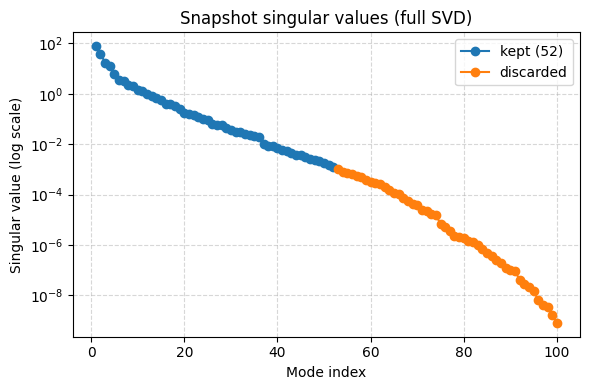

Sum of square singular values beyond cutoff (52): 3.676e-06
S ratio (tail) 4.6497e-10
S ratio (first) (52): 1.0000e+00


In [6]:
svals_full = np.linalg.svd(X, compute_uv=False)

# indices
k = np.arange(1, len(svals_full)+1)

plt.figure(figsize=(6,4))
plt.semilogy(k[:r], svals_full[:r], 'o-', color='C0', label=f'kept ({r})')
plt.semilogy(k[r:], svals_full[r:], 'o-', color='C1', label='discarded')

plt.xlabel("Mode index")
plt.ylabel("Singular value (log scale)")
plt.title("Snapshot singular values (full SVD)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

s_squared = svals_full = np.linalg.svd(X, compute_uv=False)**2
tail_sum_s_vals = s_squared[r:].sum()
sum_first_r_s_vals = s_squared[:r].sum()

error_ratio_first = sum_first_r_s_vals / s_squared.sum()
error_ratio_tail = tail_sum_s_vals / s_squared.sum()
print(f"Sum of square singular values beyond cutoff ({r}): {tail_sum_s_vals:.3e}")
print(f"S ratio (tail) {error_ratio_tail:.4e}")
print(f"S ratio (first) ({r}): {error_ratio_first:.4e}")

In [7]:
# Online reduced solve
from scipy.linalg import cho_factor, cho_solve
def solve_reduced(kappa: np.ndarray, mu_2: float = 2.0) -> np.ndarray:
    """Solve ROM for 2x2 constant κ tensor.
    
    First tries Cholesky (fast path for SPD systems).
    Falls back to np.linalg.solve if Cholesky fails.
    """
    # Assemble reduced matrix Ar(κ)
    Ar = (
          kappa[0] * A11r
        + kappa[1] * A12r
        + kappa[1] * A12r.T
        + kappa[2] * A22r
    )
    RHSr = fr + mu_2 * gr
    try:
        # Try Cholesky factorisation and solve
        c, lower = cho_factor(Ar, check_finite=False)
        y = cho_solve((c, lower), RHSr, check_finite=False)
    except Exception as e:
        # Warn and fall back
        print(f"Warning: Cholesky solve failed ({e}), using np.linalg.solve instead.")
        y = np.linalg.solve(Ar, fr)

    # Lift back to full‑order space
    return Vrb @ y

# First and last component is diagonal, middle is off-diagonal
kappa_test = np.array([1,-0.5,2])
mu_2_test = 1.0

u_rom = solve_reduced(kappa_test,mu_2_test)
u_fom = solve_full(kappa_test,mu_2=mu_2_test)

gfu_fom = GridFunction(V); gfu_fom.vec[:] = u_fom
gfu_rom = GridFunction(V); gfu_rom.vec[:] = u_rom
diff = GridFunction(V); diff.vec[:] = u_fom - u_rom
# Draw(gfu_rom, mesh, "ROM")
# Draw(gfu_fom, mesh, "FOM")

integral = Integrate(diff*diff,mesh)/Integrate(gfu_fom*gfu_fom,mesh)
print(f"Relative L2 error: {integral**0.5:.3e}")
# H1 seminorm error
h1_err = np.sqrt(Integrate(grad(diff)*grad(diff), mesh))
h1_ref = np.sqrt(Integrate(grad(gfu_fom) * grad(gfu_fom), mesh))
h1_rel = h1_err / h1_ref

print(f"Relative H1 seminorm error: {h1_rel:.3e}")

Relative L2 error: 6.114e-05
Relative H1 seminorm error: 3.954e-04


In [8]:
import time

# number of tests
n_tests = 100

# store (kappa, u_fom) for later ROM and error calculation
fom_data = []

# --- FOM timing ---
start = time.time()
for i in range(n_tests):
    # kappa = sample_anisotropic_spd(k_min=0.1, k_max=20.0, max_anisotropy=20.0)
    kappa = kappas[i]
    mu_2 = np.random.uniform(-10, 10.0)
    u_fom = solve_full(kappa, mu_2=mu_2)
    fom_data.append((kappa, mu_2, u_fom))
end = time.time()
time_fom = end - start
print(f"Time for {n_tests} FOM solves: {time_fom:.3e} seconds")

# --- ROM timing ---
rom_solutions = []
start = time.time()
for kappa_rand, mu_2, u_fom in fom_data:
    u_rom = solve_reduced(kappa_rand, mu_2=mu_2)
    rom_solutions.append(u_rom)
end = time.time()
time_rom = end-start
print(f"Time for {n_tests} ROM solves: {time_rom:.3e} seconds")
print(f"ROM is {time_fom/time_rom:.2f}x faster than FOM")
l2_errors = []
h1_errors = []

for (_, _, u_fom), u_rom in zip(fom_data, rom_solutions):
    gfu_fom = GridFunction(V); gfu_fom.vec[:] = u_fom
    gfu_rom = GridFunction(V); gfu_rom.vec[:] = u_rom
    diff = GridFunction(V); diff.vec.data = gfu_fom.vec - gfu_rom.vec

    # --- L2 relative error ---
    l2_err = sqrt(Integrate(diff*diff, mesh))
    l2_ref = sqrt(Integrate(gfu_fom*gfu_fom, mesh))
    l2_errors.append(l2_err / l2_ref)

    # --- H1 seminorm relative error ---
    h1_err = sqrt(Integrate(diff.Deriv()*diff.Deriv(), mesh))
    h1_ref = sqrt(Integrate(gfu_fom.Deriv()*gfu_fom.Deriv(), mesh))
    h1_errors.append(h1_err / h1_ref)


print(f"Mean relative L2 error over {n_tests} tests: {np.mean(l2_errors):.3e}")
print(f"Max  relative L2 error over {n_tests} tests: {np.max(l2_errors):.3e}")

print(f"Mean relative H1 error over {n_tests} tests: {np.mean(h1_errors):.3e}")
print(f"Max  relative H1 error over {n_tests} tests: {np.max(h1_errors):.3e}")


Time for 100 FOM solves: 4.381e-01 seconds
Time for 100 ROM solves: 5.006e-03 seconds
ROM is 87.52x faster than FOM
Mean relative L2 error over 100 tests: 1.245e-04
Max  relative L2 error over 100 tests: 1.867e-03
Mean relative H1 error over 100 tests: 5.781e-04
Max  relative H1 error over 100 tests: 7.352e-03
